# CS 534 Final Exam
## Zahra Ghahremani

Due 11:59 pm MDT, Friday, May 6, 2022


In [3]:
import numpy as np
from numpy.random import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Problem 1 (24 points)

**QUESTION**: Implement the Expectation Maximization (EM) algorithm for the  Gaussian Mixture Model in python.

In [4]:
from scipy.stats import norm, multivariate_normal
from sklearn.mixture import GaussianMixture
from mpl_toolkits import mplot3d
from matplotlib import cm

The EM algorithm has two steps: 1-  Expectation step (E-step) and 2- Maximisation step (M-step). The objective here is to maximize the marginal likelihood of data points given our parameters (vector θ). I consider that we have latent variables (𝛾) that are unobserved and denoted by the vector Z below and data points X. 

We should conduct two mentioned steps to predict the Gaussian Mixture model. E-step: Given our weights (π), means (µ), and covariance (Σ) of our Gaussians, we will estimate the posterior distribution of our latent variables 𝛾. θ in Figure 1 shows the vector of parameters. In this step, we can use K-means to initialize these values first (more detailed in the following code). In the next step (M-step), we will maximize the likelihood using 𝛾  and with respect to θ and we will repeat this process until the convergence of the algorithm or until we get an unchanged loss function. Gaussian Mixture distribution can be written as a combination of Gaussians with weights equal to π as below. K is the number of Gaussians we want to model here.

E-step: 

\begin{equation*}
p(x) =\sum_{i=1}^I \pi_{i} N(x|µ_{i},\sum_{i}^\ ) \\
\end{equation*}

The posterior distribution of the responsibilities that each Gaussian has for each data point can be calculated using the Bayes rule where π is the prior weights and the likelihood is normal.


\begin{equation*}
𝛾(Z_{n,i}) = \frac{\pi_{i} N(x|µ_{i},\sum_{i}^\ )}{\sum_{j=1}^I \pi_{j} N(x|µ_{j},\sum_{j}^\ )} \\
\end{equation*}

M-step: 

At this step, the parameters of each Gaussian can be estimated through the following equation and then evaluate the log-likelihood. These two steps are then repeated until convergence. So Mean of the Gaussians can be expressed as:

\begin{equation*}
µ_{i=1}^{update} = \frac{1}{N_{i}} \sum_{n=1}^N 𝛾(Z_{n,i})x_{n}   \\
\end{equation*}

covariance matrix of Gaussians:

\begin{equation*}
\sum_{i=1}^{update} = \frac{1}{N_{i}} \sum_{n=1}^N 𝛾(Z_{n,i})(x_{n}- µ_{i=1}^{update})* (x_{n}- µ_{i=1}^{update})^T\\
\end{equation*}

and weights being:

\begin{equation*}
\pi_{i=1}^{update} =\frac{N_{i}}{N}
\end{equation*}

Where

\begin{equation*}
N_{i} =\frac{N_{i}}{N}\sum_{n=1}^N 𝛾(Z_{n,i})
\end{equation*}

with the objective being the maximization of the marginal likelihood:

\begin{equation*}
ln p(X| µ, \sum, \pi) = \sum_{n=1}^N ln (\sum_{i=1}^I \pi_{i} N(x|µ_{i},\sum_{i}^\ ))
\end{equation*}




###Implementing the Expectation Maximization (EM) algorithm for the Gaussian Mixture Model

In [5]:
#Generating data
def generate_data(n_data, means, covariances, weights):
  """creates a list of data points"""
  n_clusters, n_features = means.shape
  data = np.zeros((n_data, n_features))
  for i in range(n_data):
    k = np.random.choice(n_clusters, size = 1, p = weights)[0]
    x = np.random.multivariate_normal(means[k], covariances[k])
    data[i] = x

  return data
init_means = np.array([
                       [5, 0],
                       [1, 1]
])
init_covariances = np.array([
                             [[.5, 0.], [0, .5]],
                             [[.92, .38], [.38, .91]],
])
init_weights = [1 / 4, 3 / 4]
n_data = 1000
N_Data = generate_data(n_data, init_means, init_covariances, init_weights)

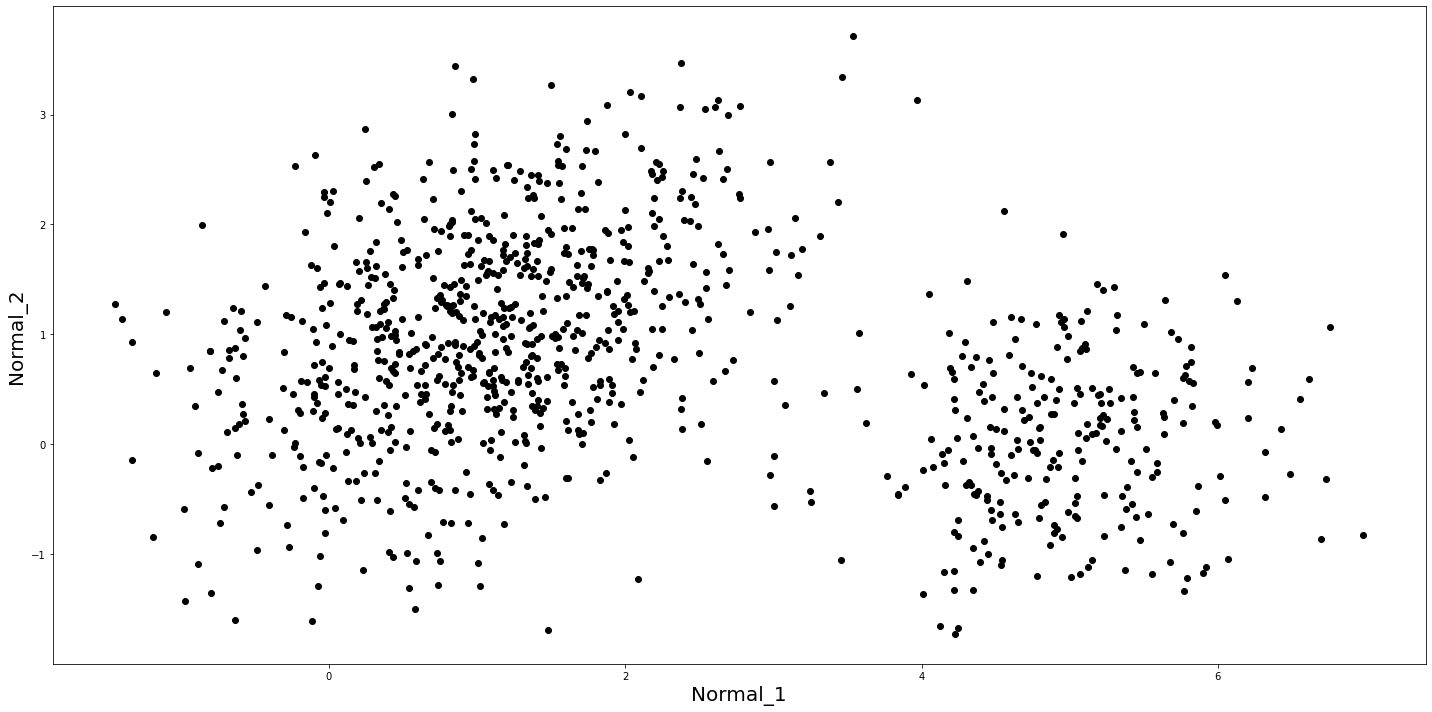

In [6]:
# Ploting
fig = plt.figure(figsize = (20,10))
X = N_Data
plt.plot(N_Data[:, 0], N_Data[:, 1], 'ko')
plt.xlabel('Normal_1',fontsize=20)
plt.ylabel('Normal_2',fontsize=20)
plt.tight_layout()

### Gaussian Mixture Model (GMM)

In [7]:
class GMM_Function:
    """
    Full covariance Gaussian Mixture Model,
    trained using Expectation Maximization.

    Parameters
    ----------
    n_components : int
        Number of clusters/mixture components in which the data will be
        partitioned into.

    n_iters : int
        Maximum number of iterations to run the algorithm.

    tol : float
        Tolerance. If the log-likelihood between two iterations is smaller than
        the specified tolerance level, the algorithm will stop performing the
        EM optimization.

    seed : int
        Seed / random state used to initialize the parameters.
    """

    def __init__(self, n_components: int, n_iters: int, tol: float, seed: int):
        self.n_components = n_components
        self.n_iters = n_iters
        self.tol = tol
        self.seed = seed
        self.log_likelihood = 0

    def fit(self, X):

        # data's dimensionality and responsibility vector
        n_row, n_col = X.shape     
        self.resp = np.zeros((n_row, self.n_components))

        # initialize parameters
        np.random.seed(self.seed)
        chosen = np.random.choice(n_row, self.n_components, replace = False)
        self.means = X[chosen]
        self.weights = np.full(self.n_components, 1 / self.n_components)
        
        # for np.cov, rowvar = False, 
        # indicates that the rows represents obervation
        shape = self.n_components, n_col, n_col
        self.covs = np.full(shape, np.cov(X, rowvar = False))

        log_likelihood = 0
        self.converged = False
        self.log_likelihood_trace = []      

        for i in range(self.n_iters):
            log_likelihood_new = self._do_estep(X)
            self._do_mstep(X)

            if abs(log_likelihood_new - log_likelihood) <= self.tol:
                self.converged = True
                break
  
            self.log_likelihood = log_likelihood_new
            self.log_likelihood_trace.append(self.log_likelihood)
            #print('likelihood is:',self.log_likelihood_trace)

        #print('likelihood is:',self.log_likelihood_trace)
        return self

    def _do_estep(self, X):
        """
        E-step: compute responsibilities,
        update resp matrix so that resp[j, k] is the responsibility of cluster k for data point j,
        to compute likelihood of seeing data point j given cluster k, use multivariate_normal.pdf
        """
        self._compute_log_likelihood(X)
        log_likelihood = np.sum(np.log(np.sum(self.resp, axis = 1)))

        # normalize over all possible cluster assignments
        self.resp = self.resp / self.resp.sum(axis = 1, keepdims = 1)
        return log_likelihood

    def _compute_log_likelihood(self, X):
        for k in range(self.n_components):
            prior = self.weights[k]
            likelihood = multivariate_normal(self.means[k], self.covs[k]).pdf(X)
            self.resp[:, k] = prior * likelihood

        return self

    def _do_mstep(self, X):
        """M-step, update parameters"""

        # total responsibility assigned to each cluster, N^{soft}
        resp_weights = self.resp.sum(axis = 0)
        
        # weights
        self.weights = resp_weights / X.shape[0]

        # means
        weighted_sum = np.dot(self.resp.T, X)
        self.means = weighted_sum / resp_weights.reshape(-1, 1)
        # covariance
        for k in range(self.n_components):
            diff = (X - self.means[k]).T
            weighted_sum = np.dot(self.resp[:, k] * diff, diff.T)
            self.covs[k] = weighted_sum / resp_weights[k]
            
        return self

###Compute the maximum likelihood values:



In [8]:
X = N_Data
gmm = GMM_Function(n_components = 2, n_iters = 30, tol = 1e-4, seed = 4)
MLE_Means = gmm.fit(X).means
MLE_Covariances = gmm.covs
MLE_PI = gmm.weights
print('The MLE PI parameter for first and seccond distribution respectively is : \n' + str(MLE_PI) + '\n')
print('The MLE mean parameter for first and seccond distribution respectively is: \n' + str(MLE_Means)+ '\n')
print('The MLE covariance parameter for first and seccond distribution respectively is: \n' + str(MLE_Covariances)+ '\n')

The MLE PI parameter for first and seccond distribution respectively is : 
[0.74008905 0.25991095]

The MLE mean parameter for first and seccond distribution respectively is: 
[[1.03551268 1.02298786]
 [4.94016382 0.02837458]]

The MLE covariance parameter for first and seccond distribution respectively is: 
[[[0.85806299 0.35407484]
  [0.35407484 0.92634971]]

 [[0.49650764 0.04747852]
  [0.04747852 0.52729611]]]



####Plot the value of the log-likelihood function vs iteration number. Comment on the pattern of the plot.



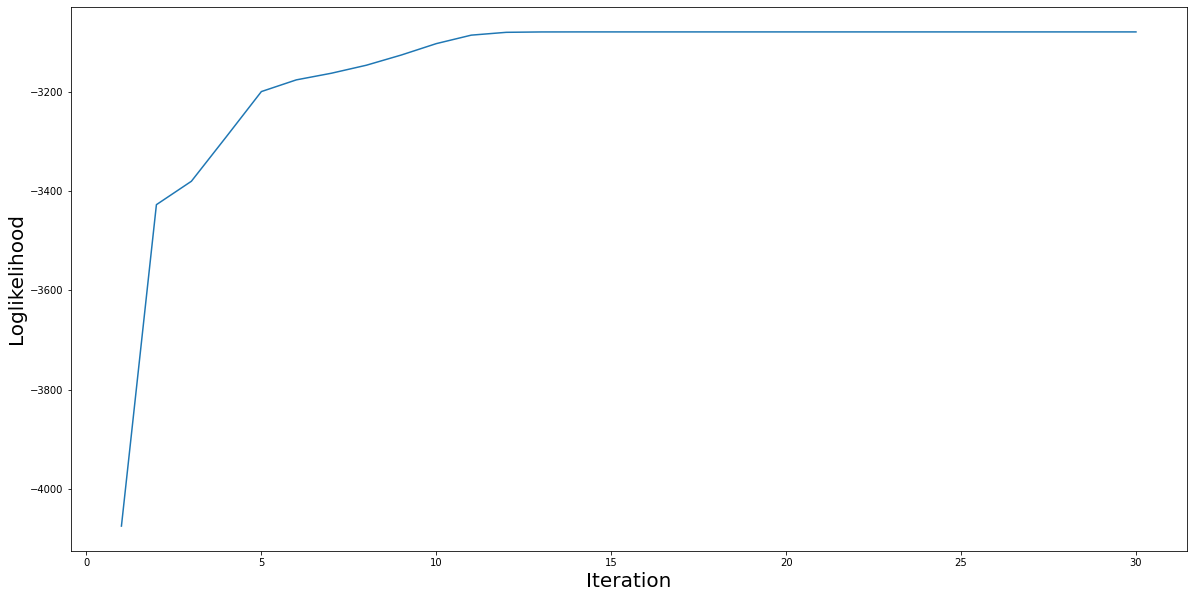

In [9]:
Liklihood = gmm.fit(X).log_likelihood_trace
X_val = np.arange(1,31,1)
plt.figure(figsize=(20,10))
plt.xlabel('Iteration',fontsize=20)
plt.ylabel('Loglikelihood',fontsize=20)
plt.plot(X_val,Liklihood)

####Classify each observation into one of the two classes. Display the classification results in a scatter plot with two different colors.



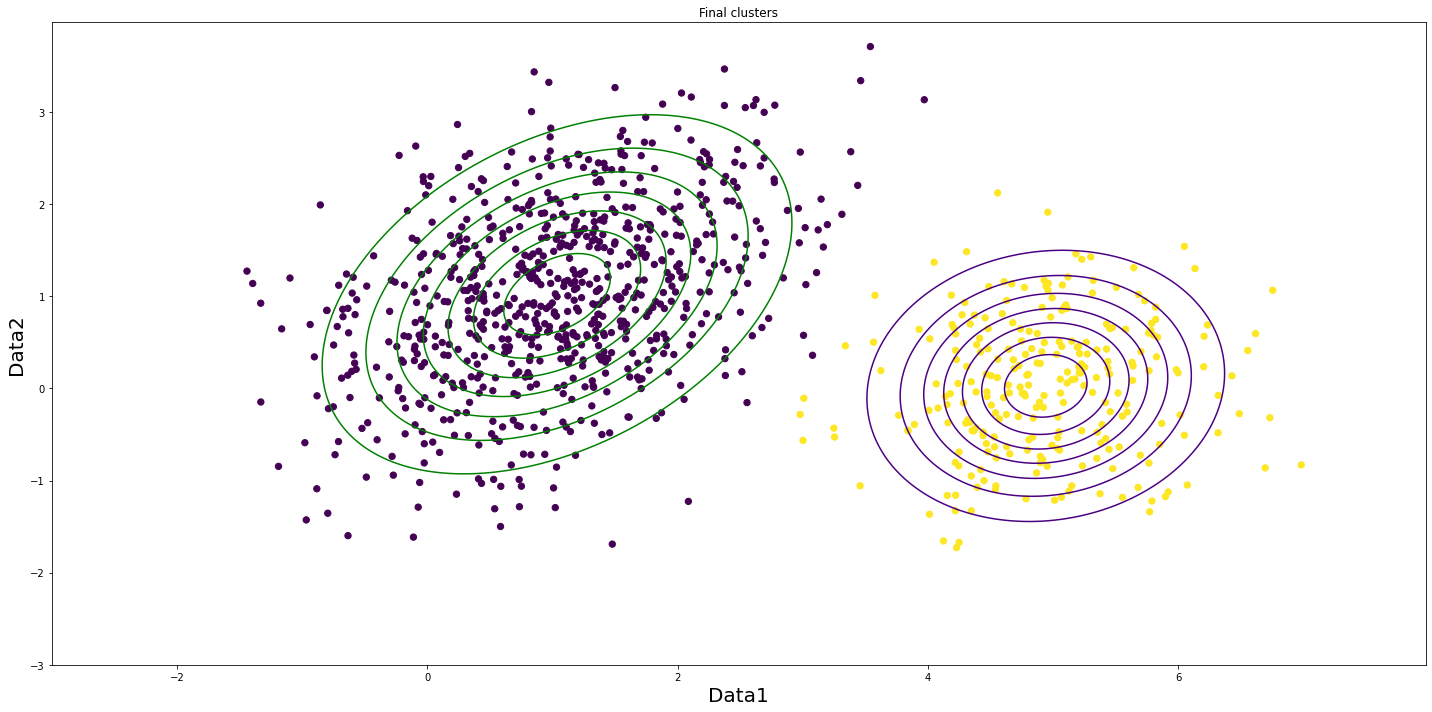

In [10]:
def plot_contours(data, means, covs, title):
    """visualize the gaussian components over the data"""
    plt.figure(figsize=(20,10))

    delta = 0.025
    k = means.shape[0]
    x = np.arange(-3.0, 8.0, delta)
    y = np.arange(-3.0, 4.0, delta)
    x_grid, y_grid = np.meshgrid(x, y)
    coordinates = np.array([x_grid.ravel(), y_grid.ravel()]).T
    gmm = GaussianMixture(n_components=2).fit(data)
    labels = gmm.predict(X)
    

    col = ['green', 'indigo']
    for i in range(k):
        mean = means[i]
        cov = covs[i]        
        z_grid = multivariate_normal(mean, cov).pdf(coordinates).reshape(x_grid.shape)
        plt.contour(x_grid, y_grid, z_grid, colors = col[i])
        
    plt.scatter(data[:, 0], data[:, 1], c=labels, s=40, cmap='viridis')
    plt.xlabel('Data1',fontsize=20)
    plt.ylabel('Data2',fontsize=20)
    plt.title(title)
    plt.tight_layout()
    
plot_contours(X, gmm.means, gmm.covs, 'Final clusters')

###Plot a surface plot of the fitted PDF f(x; θ^) .



In [11]:
def plot_surface(data, means, covs, title):
    """visualize the gaussian components over the data"""
    plt.figure(figsize=(20,15))

    delta = 0.025
    k = means.shape[0]
    x = np.arange(-3.0, 9.0, delta)
    y = np.arange(-5.0, 4.0, delta)
    x_grid, y_grid = np.meshgrid(x, y)
    coordinates = np.array([x_grid.ravel(), y_grid.ravel()]).T
    #fig = plt.figure()
    ax = plt.axes(projection='3d')
    mean1 = means[0]
    cov1 = covs[0]
    mean2 = means[1]
    cov2 = covs[1]

    z_grid = multivariate_normal(mean1, cov1).pdf(coordinates).reshape(x_grid.shape) + multivariate_normal(mean2, cov2).pdf(coordinates).reshape(x_grid.shape)
    ax.plot_surface(x_grid, y_grid, z_grid, rstride=20, cstride=20, cmap=cm.bone, edgecolors='r')
    plt.xlabel('Data1',fontsize=20)
    plt.ylabel('Data2',fontsize=20)
    ax.set_zlabel('PDF value',fontsize=20)
    plt.title(title)
    plt.tight_layout()

converged iteration: 50


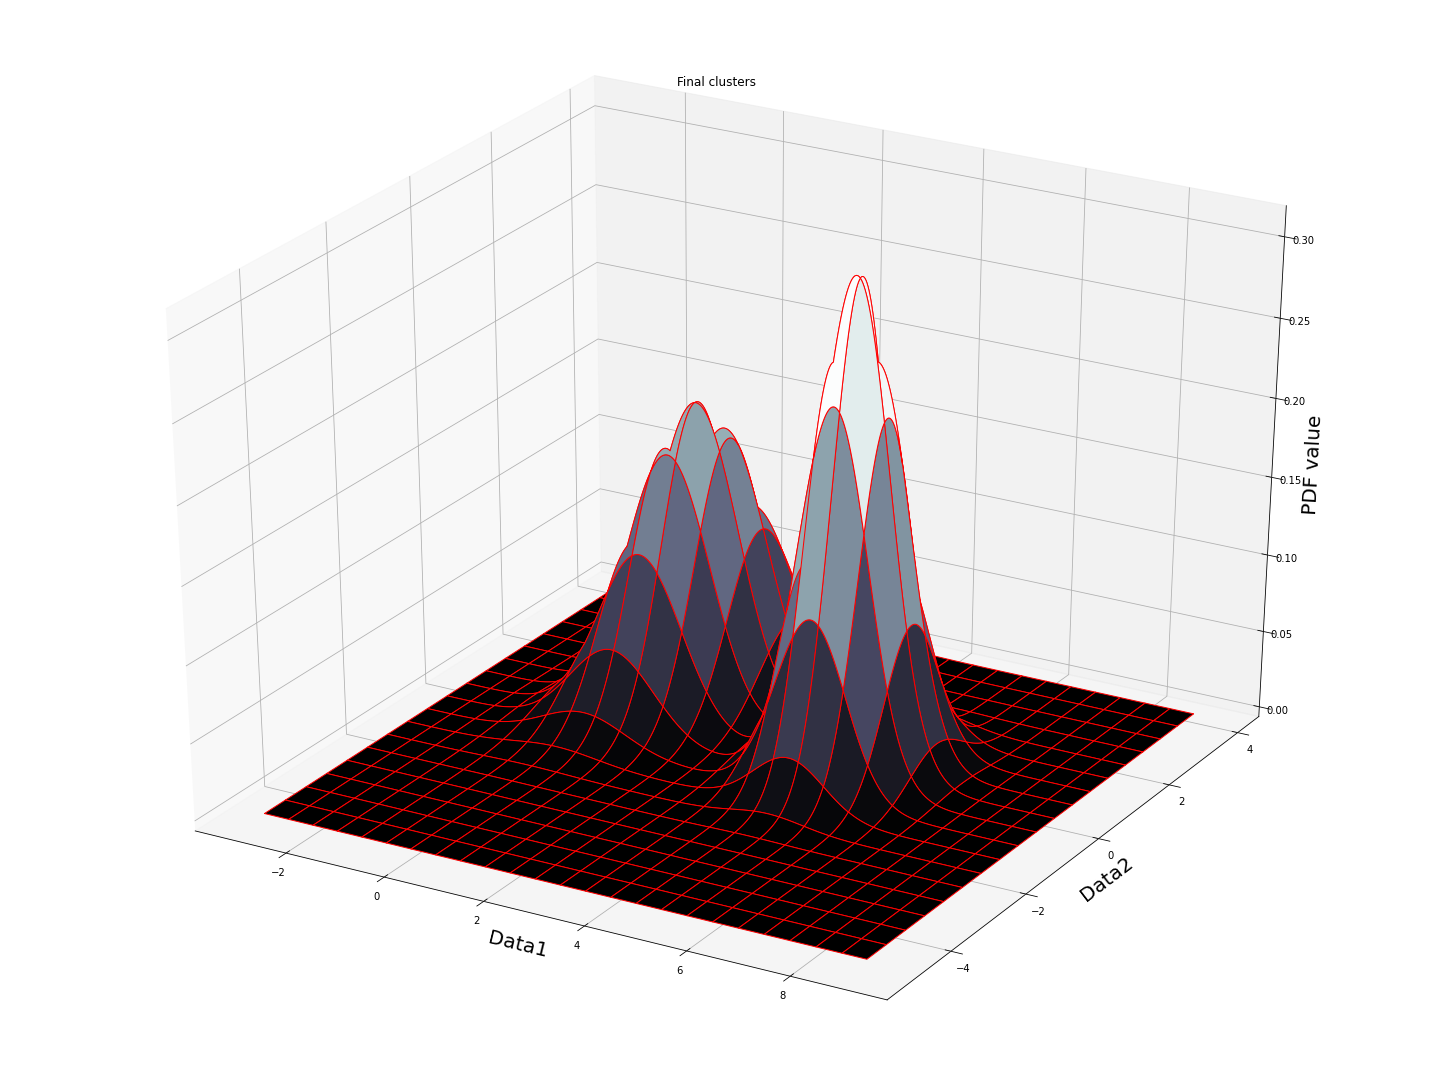

In [12]:
gmm = GMM_Function(n_components = 2, n_iters = 50, tol = 1e-4, seed = 4)
gmm.fit(X)

print('converged iteration:', len(gmm.log_likelihood_trace))
plot_surface(X, gmm.means, gmm.covs, 'Final clusters')

# Problem 2 (23 points)

**QUESTION**: Use with a dataset different from IRIS the following technique:

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html (scikit)

Explain why this technique is important.

### Feature importances with a forest of trees

 


#### The importance of this technique:

Feature importance actually considers the importance of the input features in target variable prediction and then assigns a score to them. It is calculated as the decrease in node impurity weighted by the probability of reaching that node. The node probability can be calculated by the number of samples that reach the node, divided by the total number of samples. The higher the value the more important the feature. When a specific feature has a high score, it is more effective in the model prediction. This method is practical and the basis of decreasing dimensionality or selecting a feature that can enhance the performance of the model prediction, and it’s important for the model prediction. We can use PCA to decrease dimensionality (produce independent features) when we have dependent features. However, PCA is not able to determine the efficiency and importance of original features in our calculations.

This method is useful for the following reasons:

1- Understanding the data: It can tell us how the features and target variables are related.

2- Improving the model: For dimensionality reduction in our model, we can use the scores produced by the feature importance. To improve the model’s performance and make it faster, we can use only higher scores. 

3- Model Interpretability: Since this method calculated feature scores, it’s easier to explain and interpret them.




### Loading packages

Here, I am using wine dataset to answer this question.

In [13]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import preprocessing

### Wine data

In [14]:
from sklearn.datasets import load_wine
data = load_wine()
data1 = pd.DataFrame(data= np.c_[data['data'], data['target']],
                     columns= data['feature_names'] + ['target'])
data1.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0.0


### Standardizing


(array([59.,  0.,  0.,  0.,  0., 71.,  0.,  0.,  0., 48.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

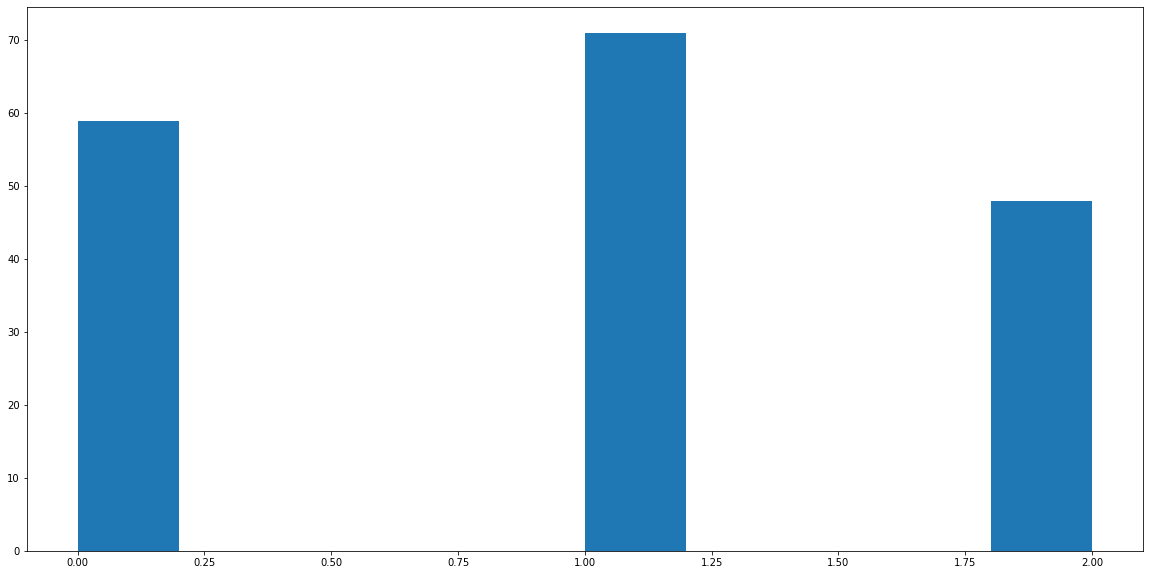

In [15]:
data = data1.iloc[:,:-1]
min_max_scaler = preprocessing.MinMaxScaler()
data = np.array(min_max_scaler.fit_transform(data))
target = np.array(data1['target'])
plt.figure(figsize=(20,10))
plt.hist(target)

### Assuming that our wine targets are only two classes 0 (combined 0 & 2) and 1.


(array([107.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  71.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

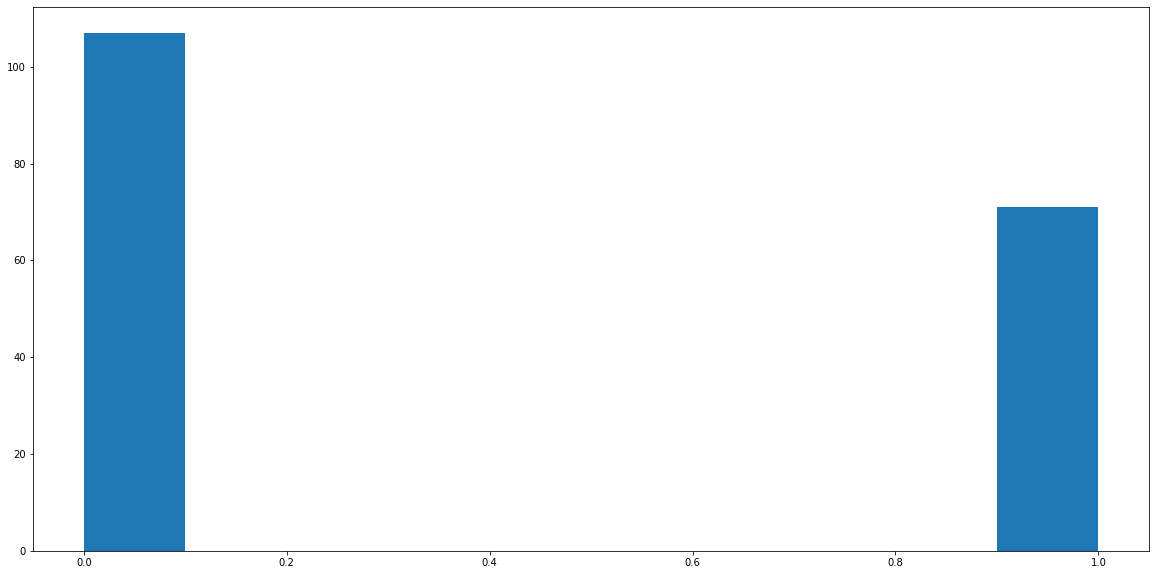

In [16]:
target[target == 2] = 0
plt.figure(figsize=(20,10))
plt.hist(target)

### Build a forest and compute the feature importances

Feature ranking:
1. feature 9 (0.187472)
2. feature 0 (0.178025)
3. feature 12 (0.164668)
4. feature 6 (0.084480)
5. feature 10 (0.058673)
6. feature 11 (0.057716)
7. feature 4 (0.057477)
8. feature 1 (0.054981)
9. feature 2 (0.048068)
10. feature 3 (0.031673)
11. feature 5 (0.030739)
12. feature 8 (0.027350)
13. feature 7 (0.018676)


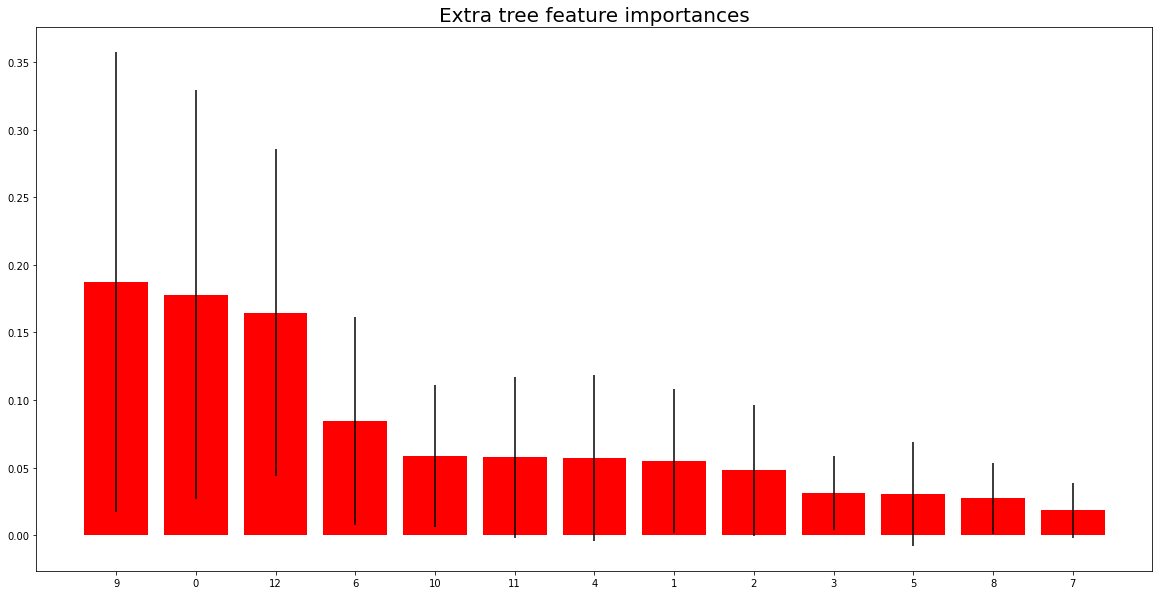

In [17]:
forest = ExtraTreesClassifier(n_estimators=250,random_state=0)

forest.fit(data, target)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(data.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Extra tree feature importances",fontsize=20)
plt.bar(range(data.shape[1]), importances[indices],color="r", yerr=std[indices], align="center")
plt.xticks(range(data.shape[1]), indices)
plt.xlim([-1, data.shape[1]])
plt.show()

# Problem 3 (23 points)

**QUESTION**: Compare by discussing results the technique in 2 with the coefficients (W) of the logistic regression. (scikit)


We can fit a LogisticRegression model on our wine dataand retrieve the coeff_ property that contains the coefficients found for each input variable. These coefficients are able to give us the basis for a crude feature importance score. This consider that the input variables have scale or have been scaled prior to fitting a model.



### labeling the species numerically

Feature ranking:
1. feature 0 (-3.229956)
2. feature 12 (-3.063830)
3. feature 9 (-2.921526)
4. feature 2 (-1.514309)
5. feature 10 (1.496983)
6. feature 1 (-1.382062)
7. feature 3 (0.901182)
8. feature 11 (0.743298)
9. feature 4 (-0.739604)
10. feature 8 (0.505559)
11. feature 6 (0.400476)
12. feature 7 (0.219398)
13. feature 5 (-0.079460)


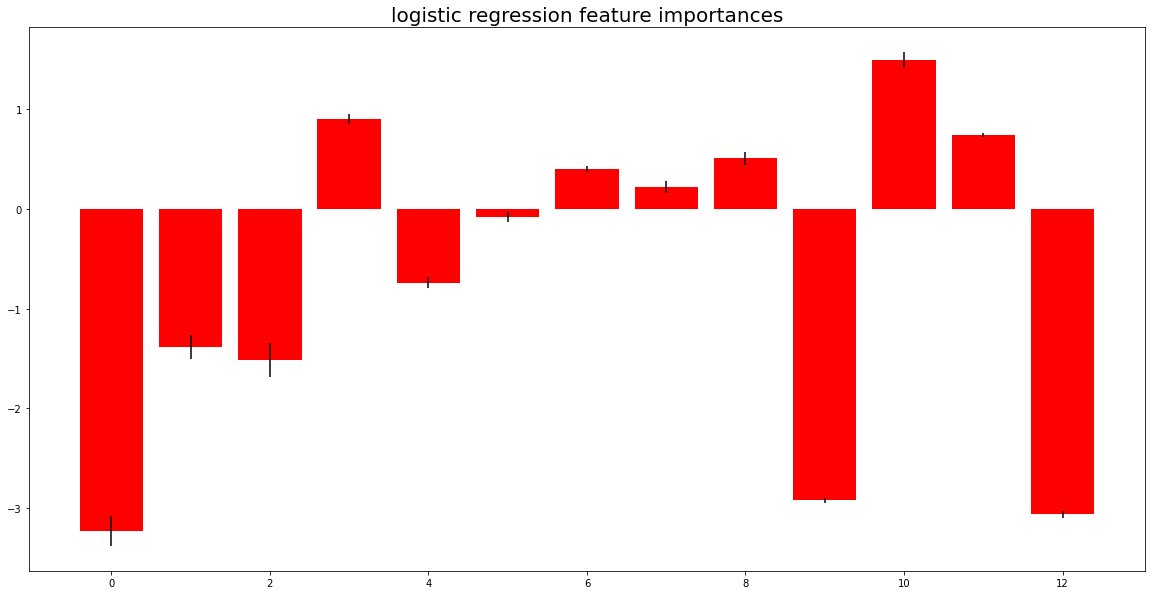

In [18]:
from sklearn.linear_model import LogisticRegression

# define the model
model = LogisticRegression()
# fit the model
model.fit(data, target)
# get importance
importance = model.coef_[0]
# summarize feature importance
indices = np.argsort(np.abs(importance))[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(data.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importance[indices[f]]))


# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.figure(figsize=(20,10))
plt.title("logistic regression feature importances",fontsize=20)
plt.bar([x for x in range(len(importance))], importance,color="r", yerr=std[indices], align="center")
plt.show()

This classification problem has two classes 1 and 0 and coefficients are positive (predict class 1) and negative (predict class 0). Logistic regression has somewhat similar result to extra tree algorithem. Both show that features 12, 0, and 9 are the most important one. Question 2, however, suggests that 6 is important while ogestic suggest that this feature is not important.

All in all, both models can be used to extract most important features that are linearly correlated with target.  However, for non linear correlations the forst method is prefered (it works better).



# Problem 4 (12 points)

**QUESTION**: Describe the main differences between K-means and DB-Scan, use examples. (scikit)

**Differences between DBScan and KMeans:**



The main difference is that they work completely differently and solve different problems. Kmeans is a least-squares optimization, whereas DBSCAN finds density-connected regions. Which technique is appropriate to use depends on your data and objectives. If you want to minimize least squares, use k-means. If you want to find density-connected regions use DBSCAN.


In [19]:
from sklearn import datasets, metrics
from sklearn.cluster import DBSCAN, KMeans
from mpl_toolkits.mplot3d import Axes3D

**Advantages and disadvantages of DBScan**


- DBScan does not need number of clusters
- DBScan needs a careful selection of parameters (sensitive to scale) 
- DBScan does not work well over clusters with different densities

### Example of DBScan succes and Kmeans failing (circles data):

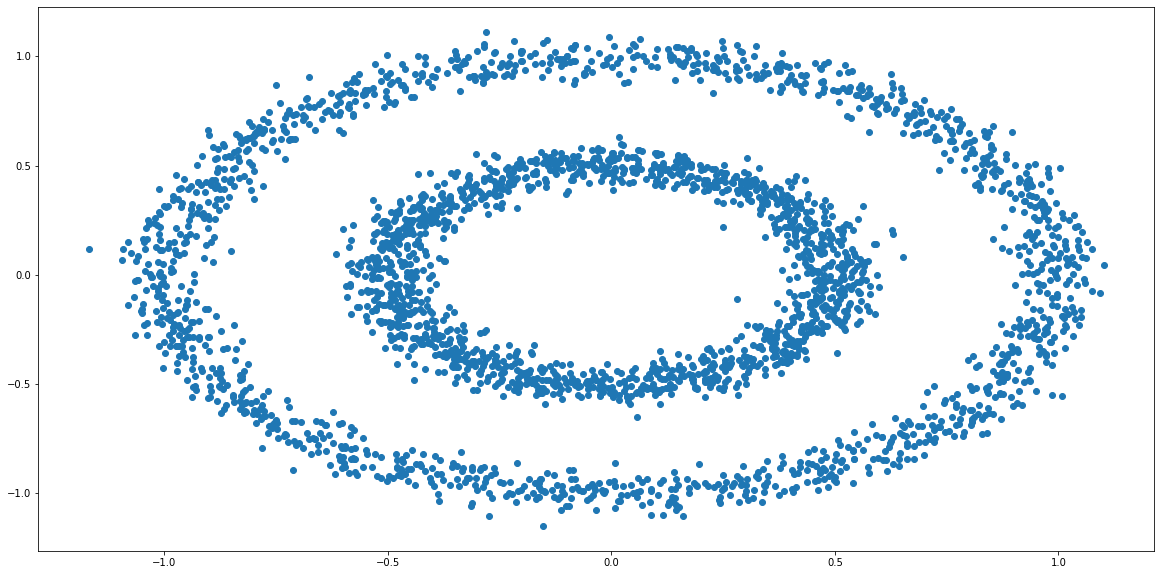

In [20]:
plt.rcParams['figure.figsize'] = (20, 10)
# Creating a sample dataset with 4 clusters
n_samples = 3000
X,y = datasets.make_circles(n_samples=n_samples, factor=.5,noise=.05)
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1])

#### DBScan

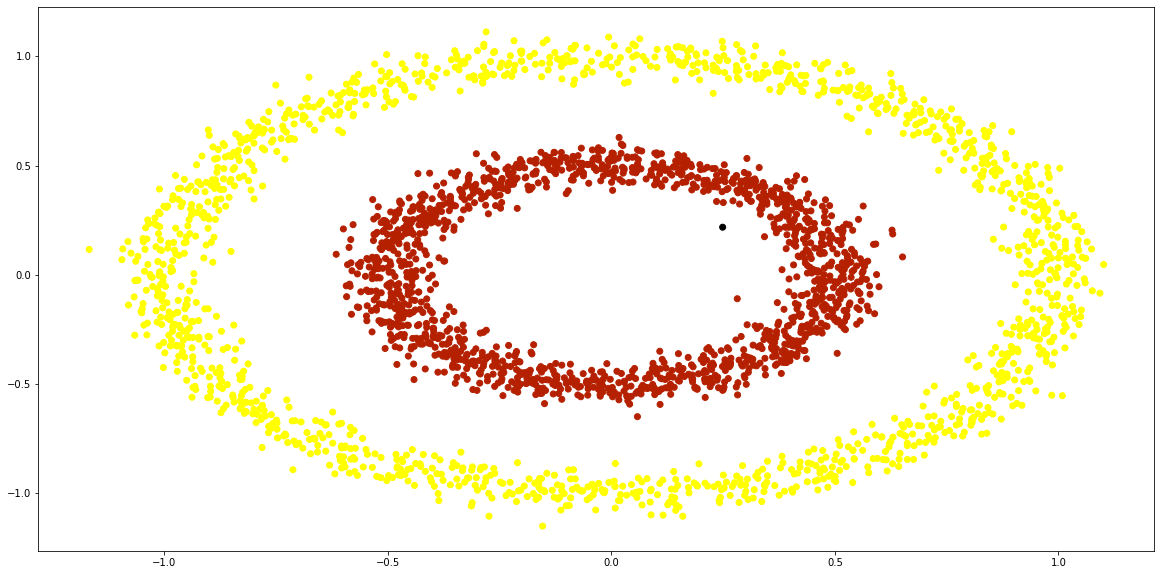

In [21]:
db = DBSCAN(eps=0.1, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=labels, alpha=1, cmap='gnuplot')

 Looking at some indices

In [22]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
labels_true=y
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 2
Estimated number of noise points: 1
Homogeneity: 1.000
Completeness: 0.996
V-measure: 0.998
Adjusted Rand Index: 0.999
Adjusted Mutual Information: 0.998
Silhouette Coefficient: -0.206


#### KMeans


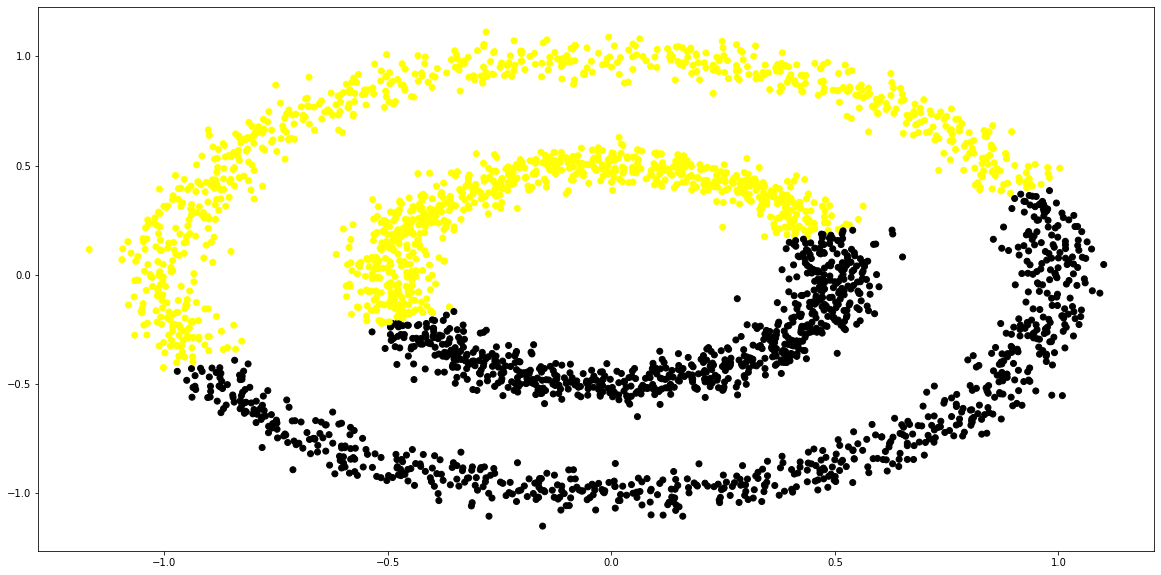

In [23]:
kmeans = KMeans(n_clusters=2)
kmeans = kmeans.fit(X)
labels = kmeans.predict(X)
C = kmeans.cluster_centers_
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=labels,alpha=1,cmap='gnuplot')

Looking at some indices

In [24]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
labels_true=y
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 2
Estimated number of noise points: 0
Homogeneity: 0.000
Completeness: 0.000
V-measure: 0.000
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000
Silhouette Coefficient: 0.355


Here, we can see that Kmeans is unable to classify this type of dataset correctly (It does not work well).

**Advantages and disadvantages of KMeans:**

- KMeans is much faster than DBScan
- Kmeans tries to create same sized cluster no matter how the data is scattered
- Kmeans doesnt work well for non-globular structures
- Kmeans doesnt care about how dense the data is present Curse of dimensionality affects kmeans at high dimension since it uses distance measure


### Example of KMeans succes and DBScan failing: (Blobs data)

/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/art3d.py:794: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/art3d.py:796: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':


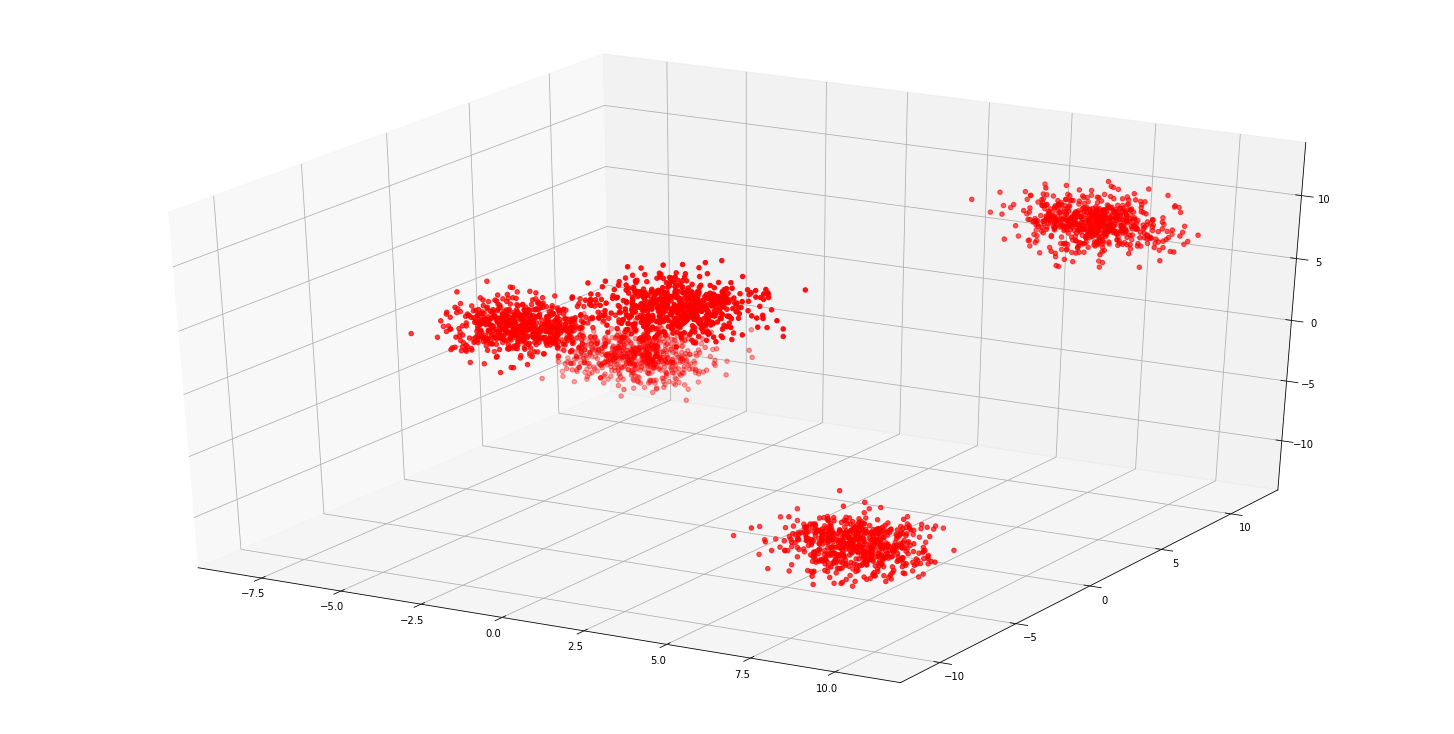

In [25]:
plt.rcParams['figure.figsize'] = (20, 10)
# Creating a sample dataset with 4 clusters
X, y = datasets.make_blobs(n_samples=3000, n_features=4, centers=5, random_state=1000)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], X[:, 3], color=['red'])

#### DBScan

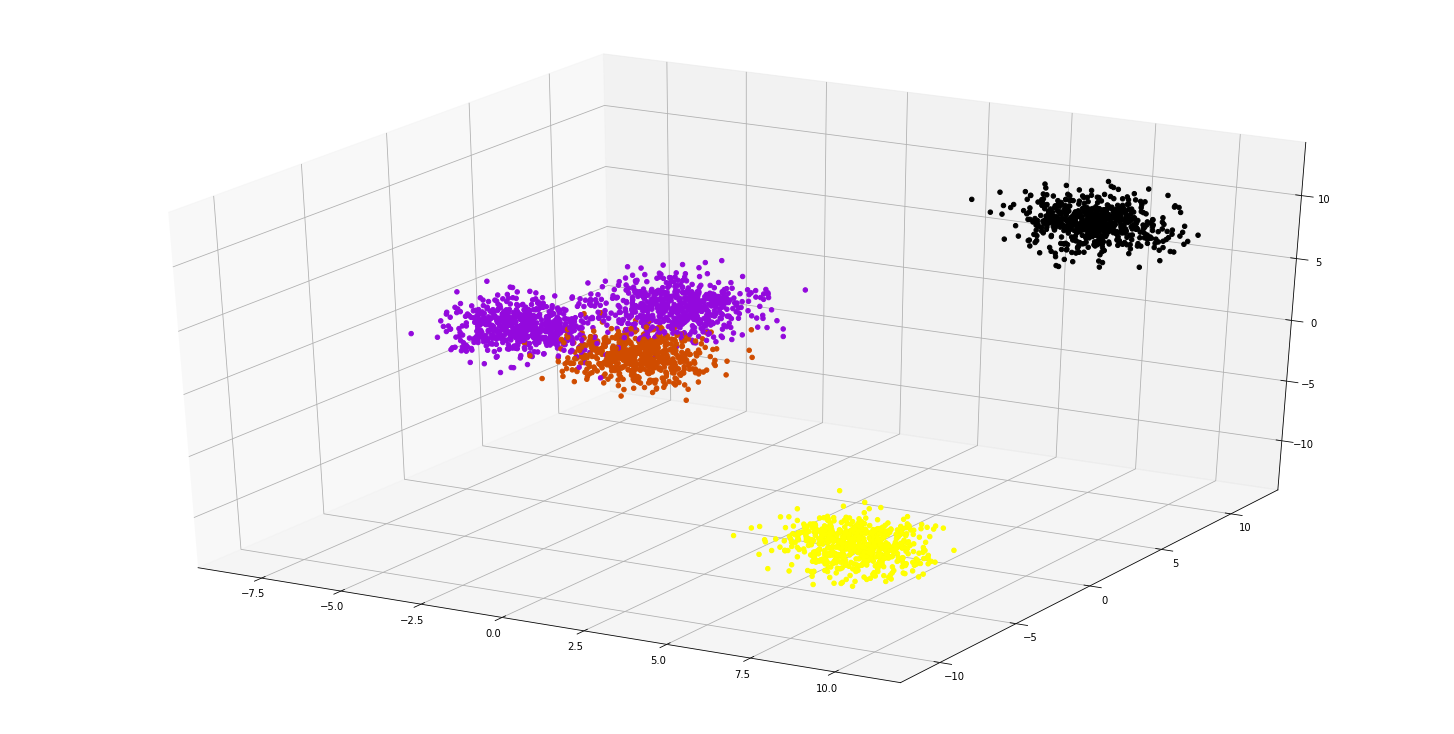

In [26]:
db = DBSCAN(eps=8, min_samples=2).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels,alpha=1,cmap='gnuplot')

Looking at some indicies

In [27]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
labels_true=y
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 4
Estimated number of noise points: 0
Homogeneity: 0.828
Completeness: 1.000
V-measure: 0.906
Adjusted Rand Index: 0.782
Adjusted Mutual Information: 0.906
Silhouette Coefficient: 0.762


#### KMeans


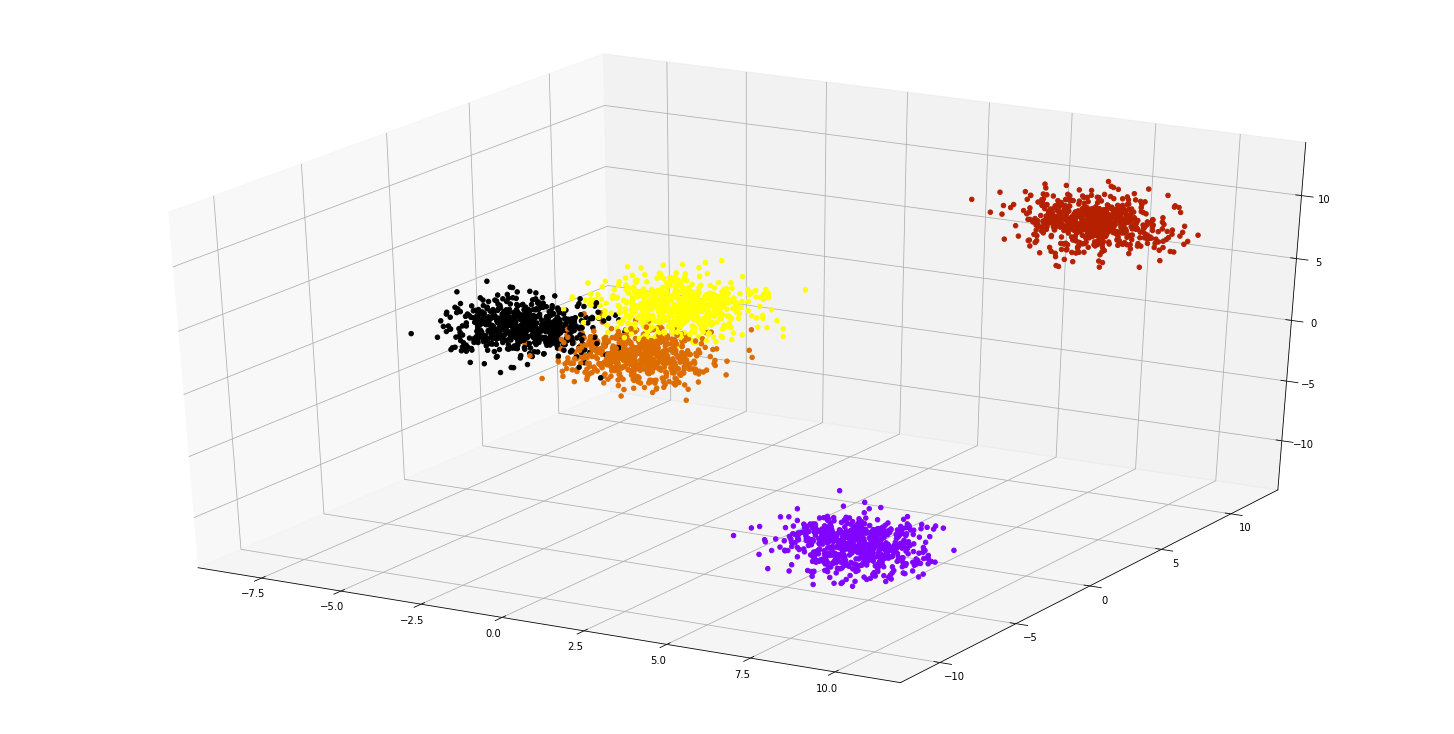

In [28]:
kmeans = KMeans(n_clusters=5)
kmeans = kmeans.fit(X)
labels = kmeans.predict(X)
C = kmeans.cluster_centers_
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels,alpha=1,cmap='gnuplot')

Looking at some indicies

In [29]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
labels_true=y
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 5
Estimated number of noise points: 0
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.814


Here, DBScan is unable to classify this type of dataset correctly and Kmeans works well.

# Problem 5 (24 points)

**QUESTION**: Implement a procedure to estimate the optimal number of clusters in the k-Means and Gaussian mixture model (try to differentiate the two procedures). (scikit)

**To solve this problem, I collaborated  with Yavar Pourmohamad**

**Evaluation Methods**

In supervised learning we have the ground truth for evaluating the model’s performance, however, clustering analysis doesn’t have a solid evaluation metric that we can use to evaluate the outcome of different clustering algorithms. Furthemore, since kmeans requires k as an input and doesn’t learn it from data, there is no right answer in terms of the number of clusters that we should have in any problem. Sometimes domain knowledge and intuition may help but usually that is not the case. In the cluster-predict methodology, we can evaluate how well the models are performing based on different K clusters since clusters are used in the downstream modeling. In this post I’ll cover two metrics that may give us some intuition about k:

- Elbow method (uses the sum of squared distance (SSE) for defining the number of clusters)
- Silhouette analysis
- Akaike information criterion (AIC)
- Bayesian information criterion (BIC)

I'll use Elbow method on KMeans and BIC on GaussianMixture:


### Generating data

In [30]:
from sklearn.metrics import silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

<Figure size 1440x720 with 0 Axes>

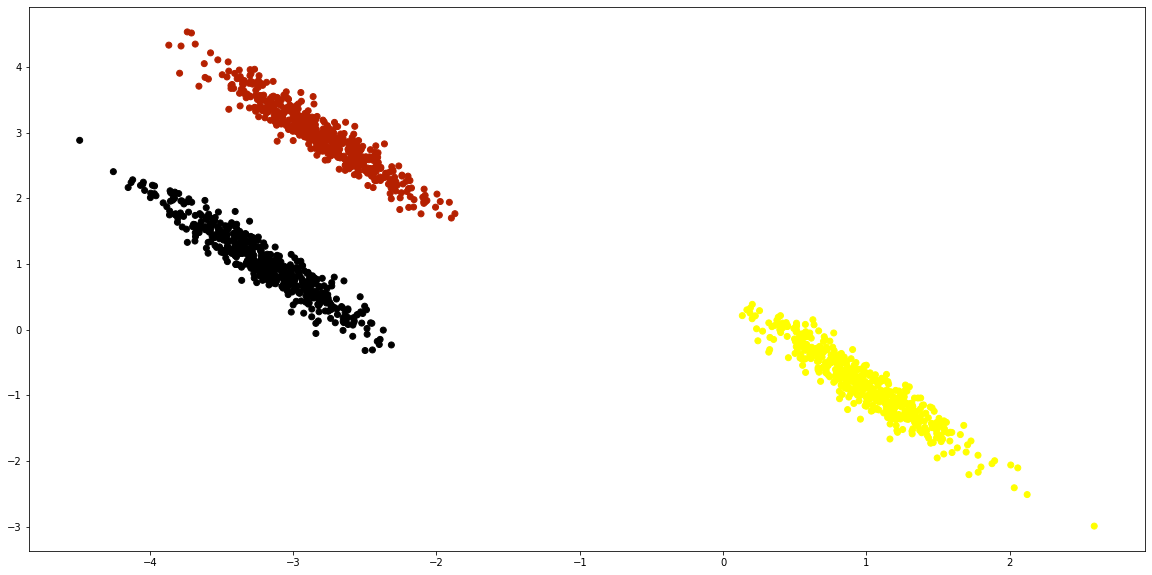

In [31]:
random_state = 170
n_samples = 1500
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state,cluster_std=0.5)
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
X_std=StandardScaler().fit_transform(X_aniso)
fig = plt.figure()
plt.figure(figsize=(20,10))
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y,alpha=1,cmap='gnuplot')

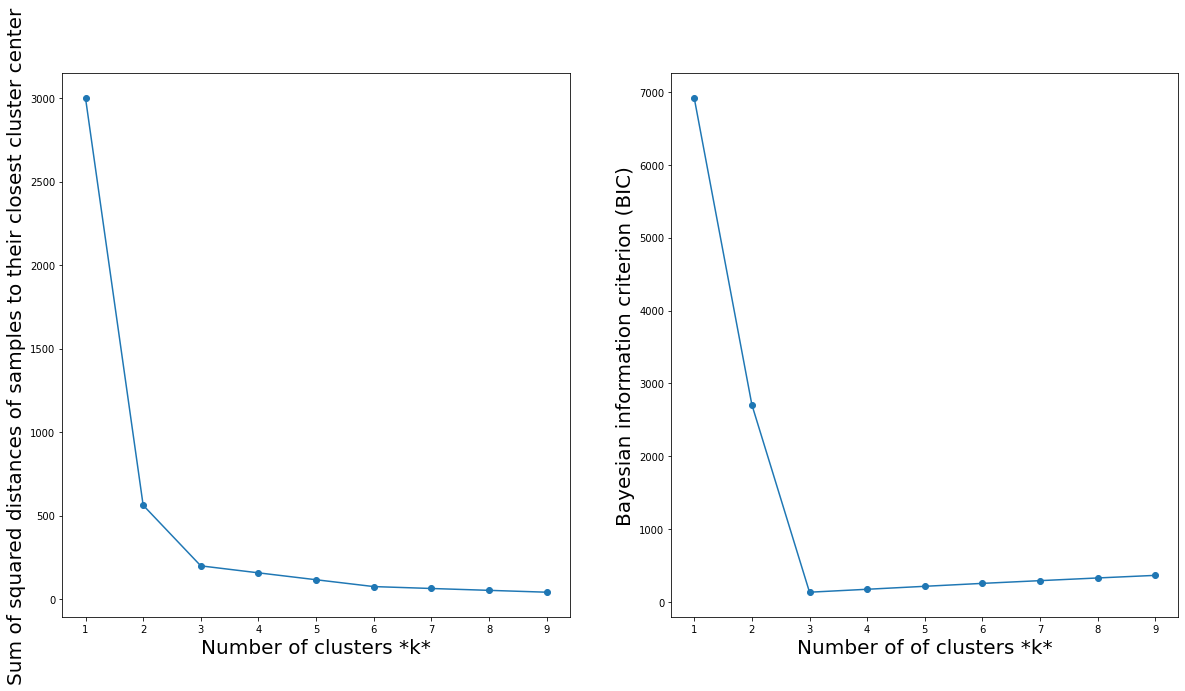

In [32]:
# Kmeans algorithm
sse_kmean = []
sse_gmm = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k).fit(X_std)
    sse_kmean.append(km.inertia_)
    gmm = GaussianMixture(n_components=k).fit(X_std)
    sse_gmm.append(gmm.bic(X_std))
    
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)

plt.plot(list_k, sse_kmean, '-o')
plt.xlabel(r'Number of clusters *k*',fontsize=20)
plt.ylabel('Sum of squared distances of samples to their closest cluster center',fontsize=20)

plt.subplot(1, 2, 2)
plt.plot(list_k, sse_gmm, '-o')
plt.xlabel(r'Number of of clusters *k*',fontsize=20)
plt.ylabel('Bayesian information criterion (BIC)',fontsize=20)
plt.show()

Both methods suggest that both KMeans and GaussianMixture find 3 clusters as optimum amount.


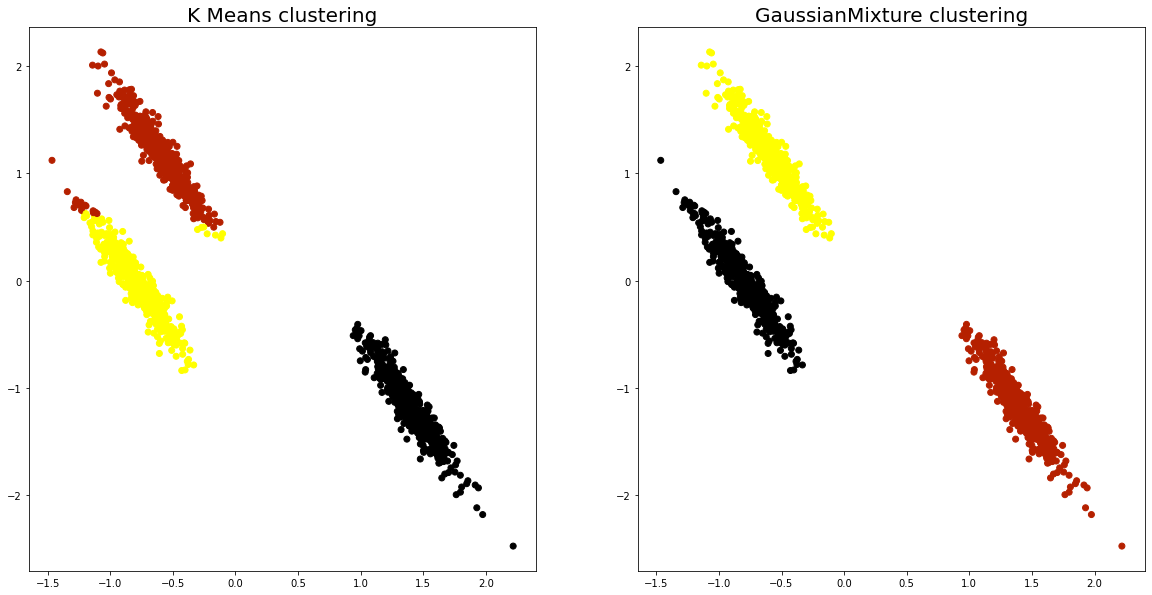

In [33]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)

km = KMeans(n_clusters=3).fit(X_std)
labels_kmean = km.labels_
plt.scatter(X_std[:, 0], X_std[:, 1], c=labels_kmean,alpha=1,cmap='gnuplot')
plt.title('K Means clustering',fontsize=20)

plt.subplot(1, 2, 2)
gmm = GaussianMixture(n_components=3).fit(X_std)
labels_gmm = gmm.predict(X_std)
plt.scatter(X_std[:, 0], X_std[:, 1], c=labels_gmm,alpha=1,cmap='gnuplot')
plt.title('GaussianMixture clustering',fontsize=20)
plt.show()

**Silhouette analysis and AIC**

We use Silhouette analysis on KMeans and AIC on GaussianMixture:

Now lets look more closly at 2, 3, and 4 clusters.


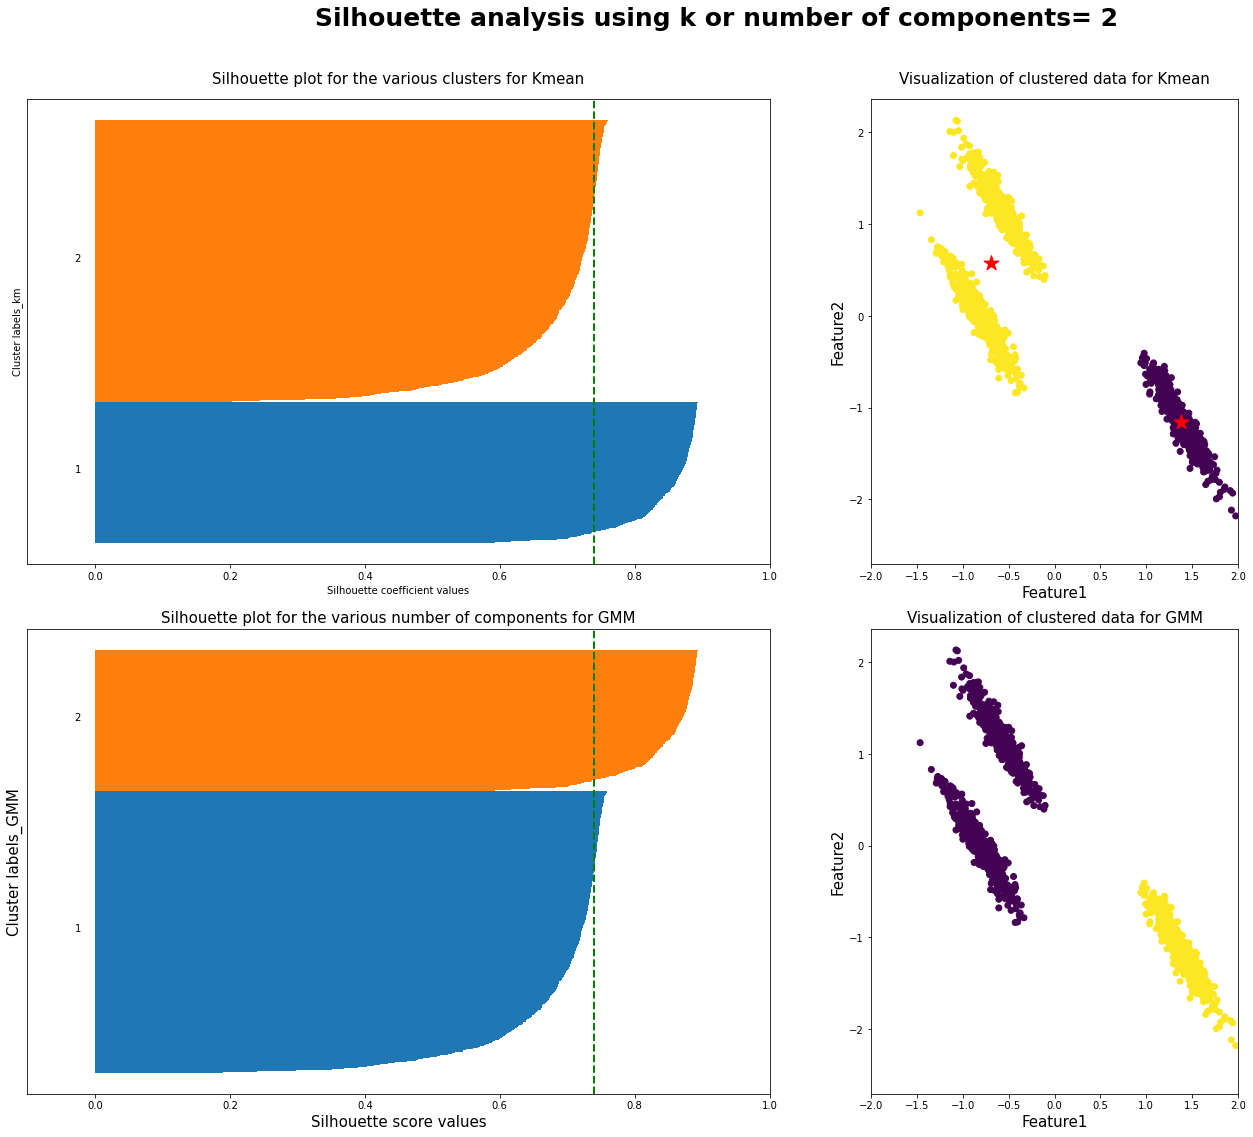

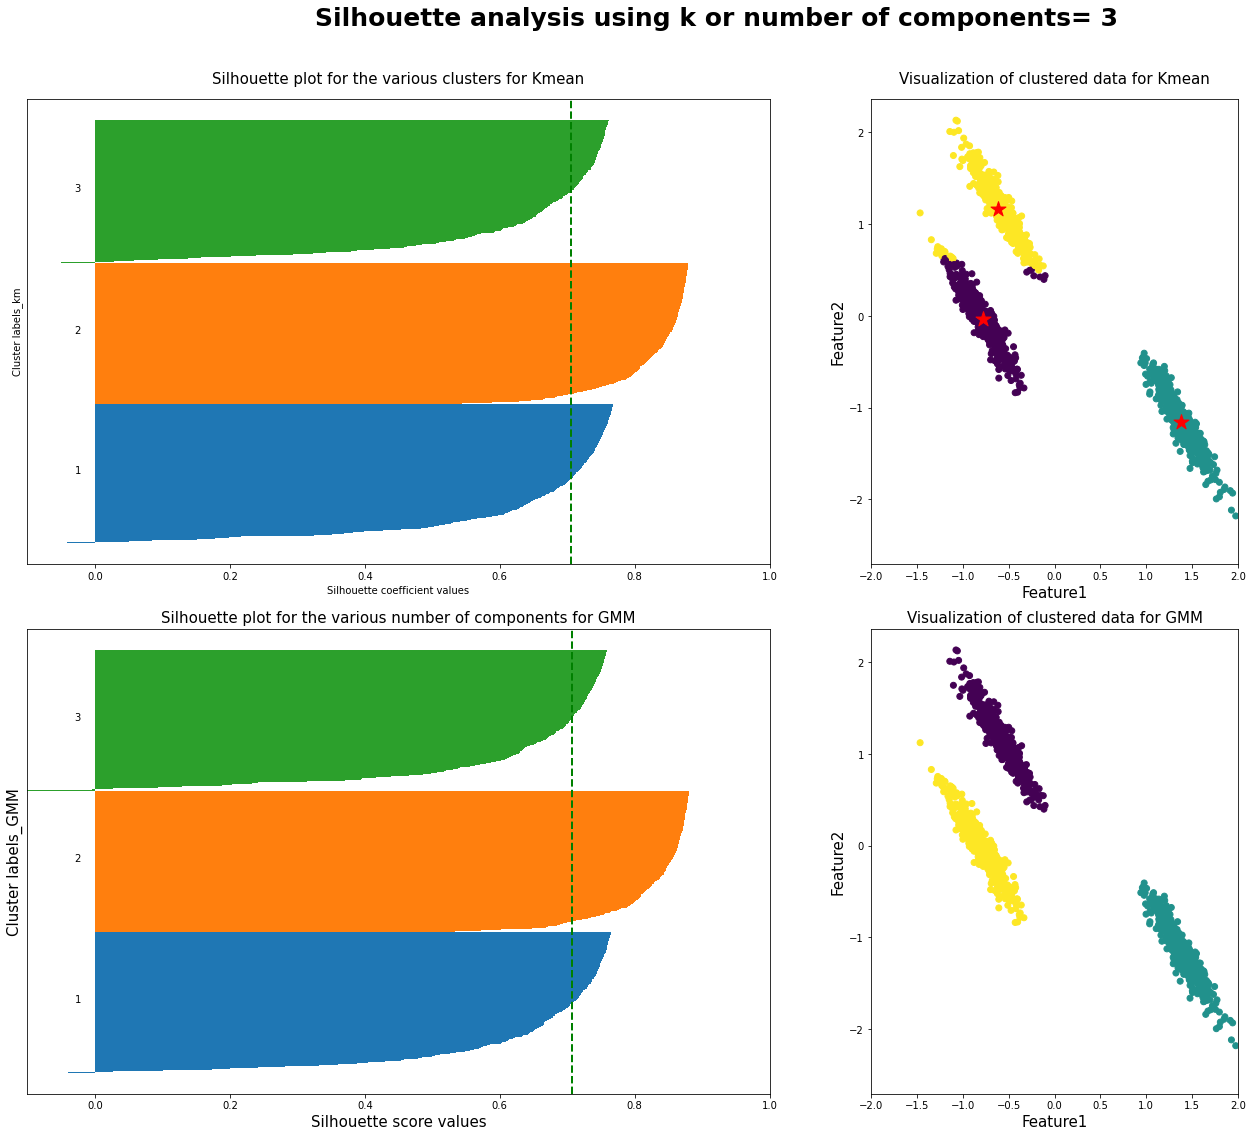

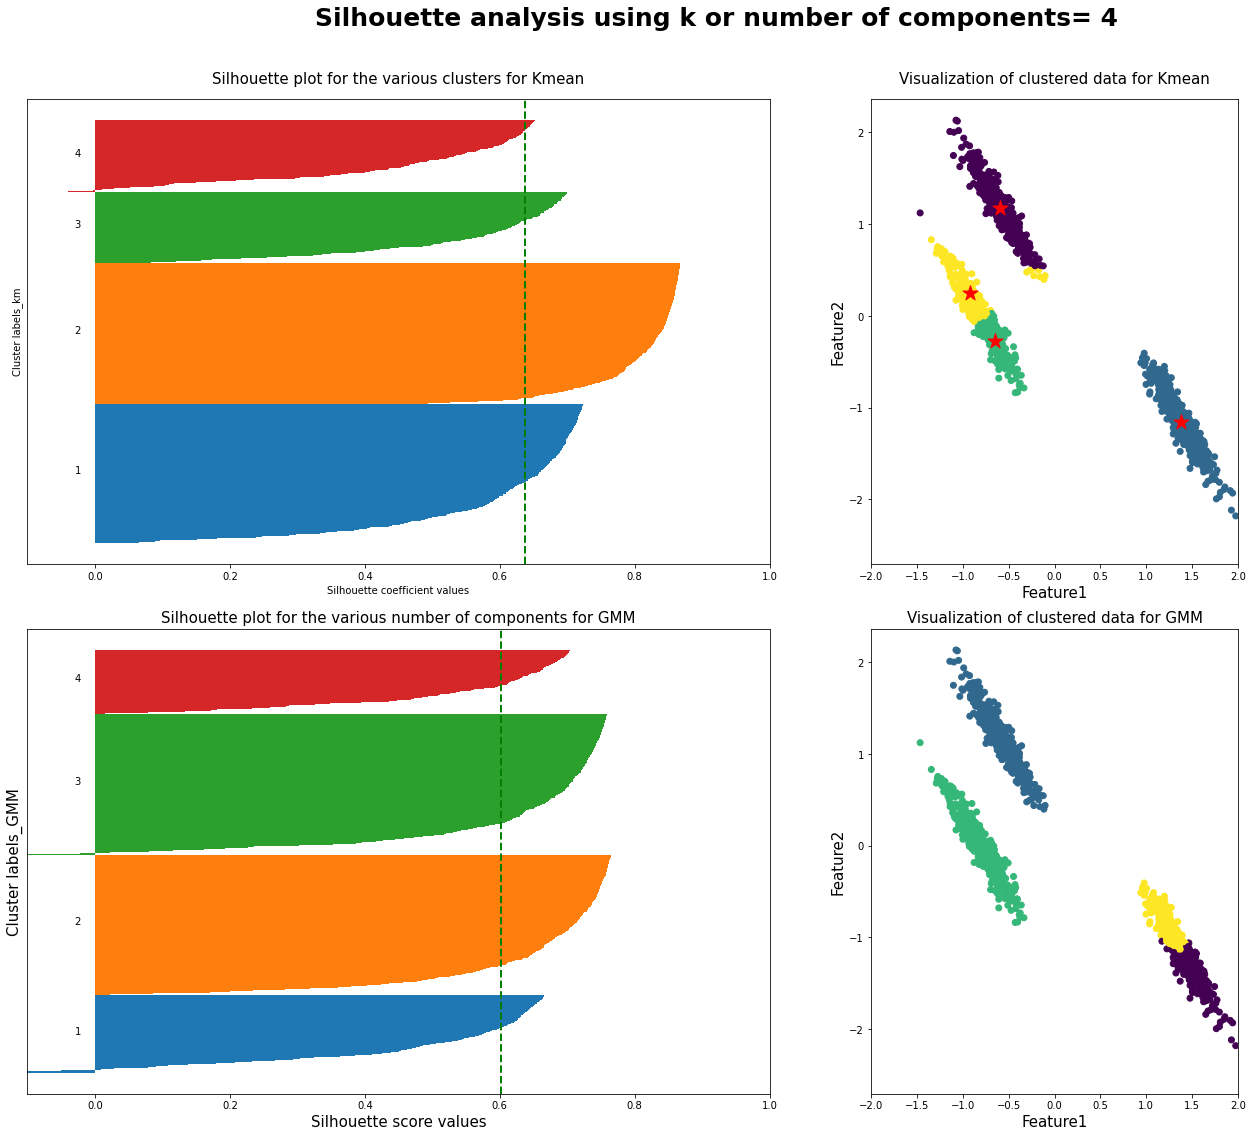

In [34]:
for i, k in enumerate([2, 3, 4]):
    fig, axis = plt.subplots(2, 2,figsize=[20,15])
    axis = axis.flatten()
    ax1, ax2,ax3,ax4=axis
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels_km = km.fit_predict(X_std)
    centroids = km.cluster_centers_
    
    gmm = GaussianMixture(n_components=k)
    labels_gmm = gmm.fit_predict(X_std)
    

    # Get silhouette samples
    silhouette_vals = silhouette_samples(X_std, labels_km)
    
    # AIC 
    AIC_vals = silhouette_samples(X_std, labels_gmm)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels_km)):
        cluster_silhouette_vals = silhouette_vals[labels_km == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)
        
    # AIC plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels_gmm)):
        cluster_AIC_vals = AIC_vals[labels_gmm == cluster]
        cluster_AIC_vals.sort()
        y_upper += len(cluster_AIC_vals)
        ax3.barh(range(y_lower, y_upper), cluster_AIC_vals, edgecolor='none', height=1)
        ax3.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_AIC_vals)

    # Get the average silhouette score and plot it
    
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values',fontsize=10)
    ax1.set_ylabel('Cluster labels_km',fontsize=10)
    ax1.set_title('Silhouette plot for the various clusters for Kmean', y=1.02,fontsize=15);
    
    
    
    # Scatter plot of data colored with labels_km
    ax2.scatter(X_std[:, 0], X_std[:, 1], c=labels_km)
    ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    ax2.set_xlim([-2, 2])
    ax2.set_xlim([-2, 2])
    ax2.set_xlabel('Feature1',fontsize=15)
    ax2.set_ylabel('Feature2',fontsize=15)
    ax2.set_title('Visualization of clustered data for Kmean', y=1.02,fontsize=15)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);
    # Get the average AIC score and plot it
    avg_score = np.mean(AIC_vals)
    ax3.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax3.set_yticks([])
    ax3.set_xlim([-0.1, 1])
    ax3.set_xlabel('Silhouette score values',fontsize=15)
    ax3.set_ylabel('Cluster labels_GMM',fontsize=15)
    ax3.set_title('Silhouette plot for the various number of components for GMM', y=1.02,fontsize=15);
    
    # Scatter plot of data colored with labels_gmm
    ax4.scatter(X_std[:, 0], X_std[:, 1], c=labels_gmm)
    ax4.set_xlim([-2, 2])
    ax4.set_xlim([-2, 2])
    ax4.set_xlabel('Feature1',fontsize=15)
    ax4.set_ylabel('Feature2',fontsize=15)
    ax4.set_title('Visualization of clustered data for GMM', y=1.02,fontsize=15)
    ax4.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k or number of components= {k}',
                 fontsize=25, fontweight='semibold', y=1.05);

As the above silhouette score plots show, n_clusters=2 has the best average silhouette score of around 0.75 and all clusters being above the average shows that it is actually a good choice. Also, the thickness of the silhouette plot gives an indication of how big each cluster is.




###Now lets try AIC:


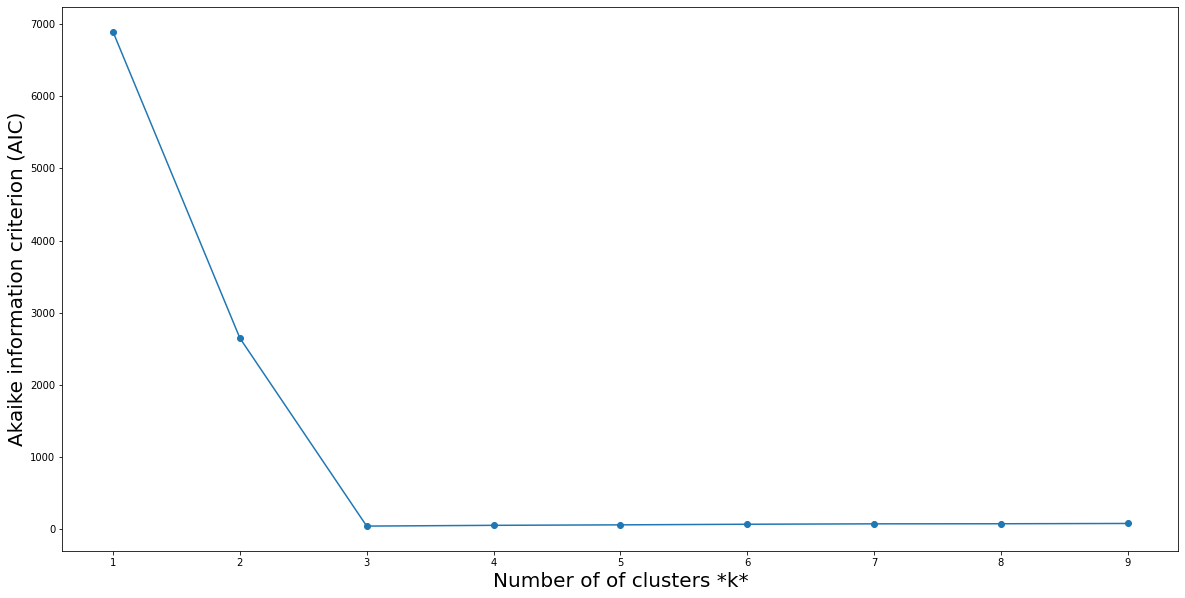

In [35]:
sse_gmm = []
list_k = list(range(1, 10))

for k in list_k:
    gmm = GaussianMixture(n_components=k).fit(X_std)
    sse_gmm.append(gmm.aic(X_std))
    
plt.figure(figsize=(20,10))

plt.plot(list_k, sse_gmm, '-o')
plt.xlabel(r'Number of of clusters *k*',fontsize=20)
plt.ylabel('Akaike information criterion (AIC)',fontsize=20)
plt.show()

AIC suggest that 3 is optimum number of cluster for GMM.


# Problem 6 (24 points)

**QUESTION**: Implement the algorithm of hierarchical clustering with maximum or complete linkage 

(this can help www.econ.upf.edu/~michael/stanford/maeb7.pdf)

**Single-Linkage**


Single-linkage (nearest neighbor) is the shortest distance between a pair of observations in two clusters. It can sometimes produce clusters where observations in different clusters are closer together than to observations within their own clusters. These clusters can appear spread-out. 

**Complete-Linkage**

Complete-linkage (farthest neighbor) is where distance is measured between the farthest pair of observations in two clusters. This method usually produces tighter clusters than single-linkage, but these tight clusters can end up very close together. Along with average-linkage, it is one of the more popular distance metrics.

In [36]:
import math
from scipy.spatial import distance
from sklearn.model_selection import train_test_split

### Use the generated data in problem 1

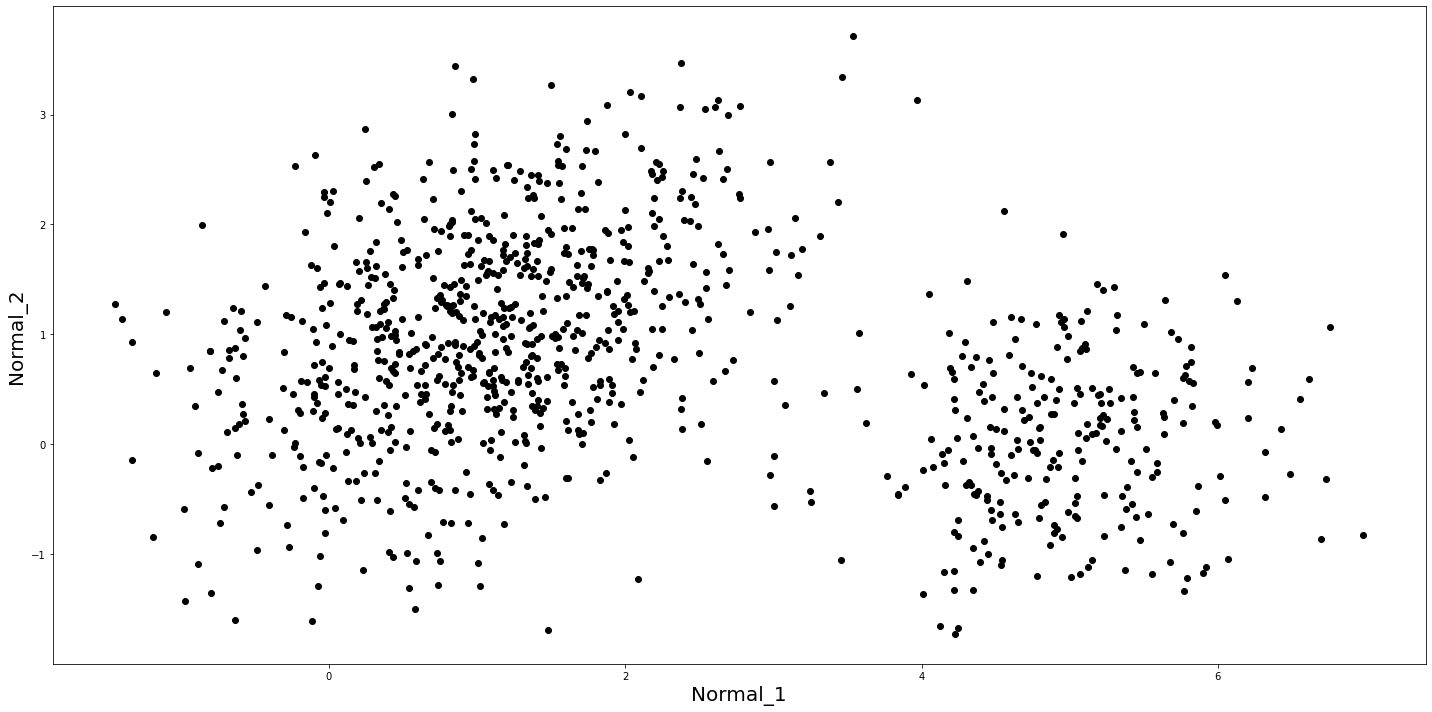

In [37]:
fig = plt.figure(figsize = (20,10))
X=data
plt.plot(N_Data[:, 0], N_Data[:, 1], 'ko')
plt.xlabel('Normal_1',fontsize=20)
plt.ylabel('Normal_2',fontsize=20)
plt.tight_layout()

In [38]:
# Train and Test data
data_train, data_test = train_test_split(np.array(N_Data),  test_size=0.3, random_state=1000)
Data = pd.DataFrame(data_test,columns=['x0', 'x1'])

**Build a Hierachical model**



In [39]:
def hierarchical(data, cluster_num, metric):
    # initialization of clusters at first (every point is a cluster)
    init_clusters=[]
    for index, row in data.iterrows():
        init_clusters.append([[row['x0'], row['x1']]])
    if metric is 'single':
        return single_distance(init_clusters, cluster_num)
    else:
        #metric is 'complete':
        return complete_distance(init_clusters, cluster_num)

**Build Single linkage**



In [40]:
def single_distance(clusters ,cluster_num):
  #print('first cluster | ','second cluster | ', 'distance')
  while len(clusters) is not cluster_num:
    # Clustering
    closest_distance=clust_1=clust_2 = math.inf
    # for every cluster (until second last element)
    for cluster_id, cluster in enumerate(clusters[:len(clusters)]):
      # for each point in each cluster
      for point_id,point in enumerate(cluster): 
        # we only need to compare with clusters after the current one
        for cluster2_id, cluster2 in enumerate(clusters[(cluster_id+1):]):
          # go through every point in this prospective cluster as well
          for point2_id, point2 in enumerate(cluster2):
            # if this distance is better than our previous best distance then we are going to overwrite it
            if distance.euclidean(point,point2) < closest_distance: 
              # Only used for comparing 
              closest_distance = distance.euclidean(point,point2)
              # this will be used at the end to figure out which cluster to merge with which
              clust_1 = cluster_id
              # this cluster will be destroyed by the end
              clust_2 = cluster2_id+cluster_id+1
              # extend just appends the contents to the list without flattening it out
    #print(clust_1,' | ',clust_2, ' | ',closest_distance)
    clusters[clust_1].extend(clusters[clust_2]) 
    # don't need this index anymore, and we have just clustered once more
    clusters.pop(clust_2) 
  return(clusters)

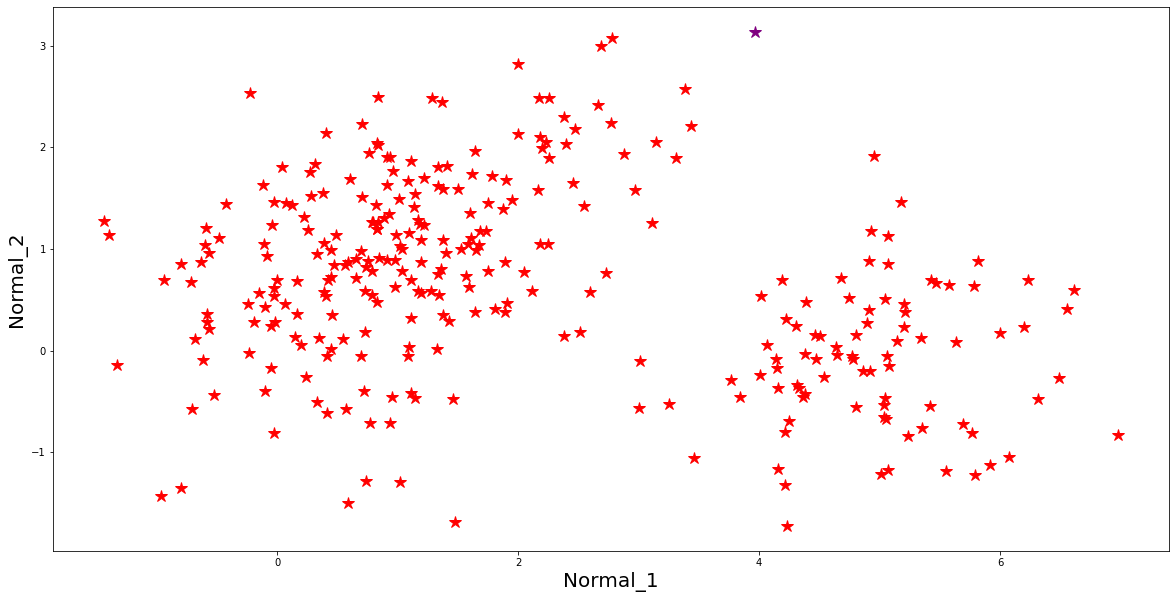

In [41]:
clusters = hierarchical(Data, 2, 'single')
colors = ['red', 'purple']
plt.xlabel('Normal_1',fontsize=20)
plt.ylabel('Normal_2',fontsize=20)
for cluster_index, cluster in enumerate(clusters):
    for point_index, point in enumerate(cluster):
        plt.plot([point[0]], [point[1]], marker='*', markersize=12, color=colors[cluster_index])

**Build Complete linkage**


In [42]:
def complete_distance(clusters ,cluster_num):
    #print('first cluster | ','second cluster | ', 'distance')
    while len(clusters) is not cluster_num:
        # Clustering           (
        closest_distance=clust_1=clust_2 = math.inf
        # for every cluster (until second last element)
        for cluster_id, cluster in enumerate(clusters[:len(clusters)]): 
            for cluster2_id, cluster2 in enumerate(clusters[(cluster_id+1):]):  
                furthest_cluster_dist = -1
                # this is different from the complete link in that we try to minimize the MAX distance
                # between CLUSTERS
                # go through every point in this prospective cluster as well
                # for each point in each cluster
                for point_id,point in enumerate(cluster): 
                    for point2_id, point2 in enumerate(cluster2):
                        # make sure that our furthest distance holds the maximum distance betweeen the clusters at focus
                        if furthest_cluster_dist < distance.euclidean(point,point2): 
                            furthest_cluster_dist = distance.euclidean(point,point2)
                            # We are now trying to minimize THAT furthest dist
                if furthest_cluster_dist < closest_distance:
                    closest_distance = furthest_cluster_dist
                    clust_1 = cluster_id
                    clust_2 = cluster2_id+cluster_id+1
                   # extend just appends the contents to the list without flattening it out
        #print(clust_1,' | ',clust_2, ' | ',closest_distance)
        clusters[clust_1].extend(clusters[clust_2]) 
        # don't need this index anymore, and we have just clustered once more
        clusters.pop(clust_2) 
    return(clusters)

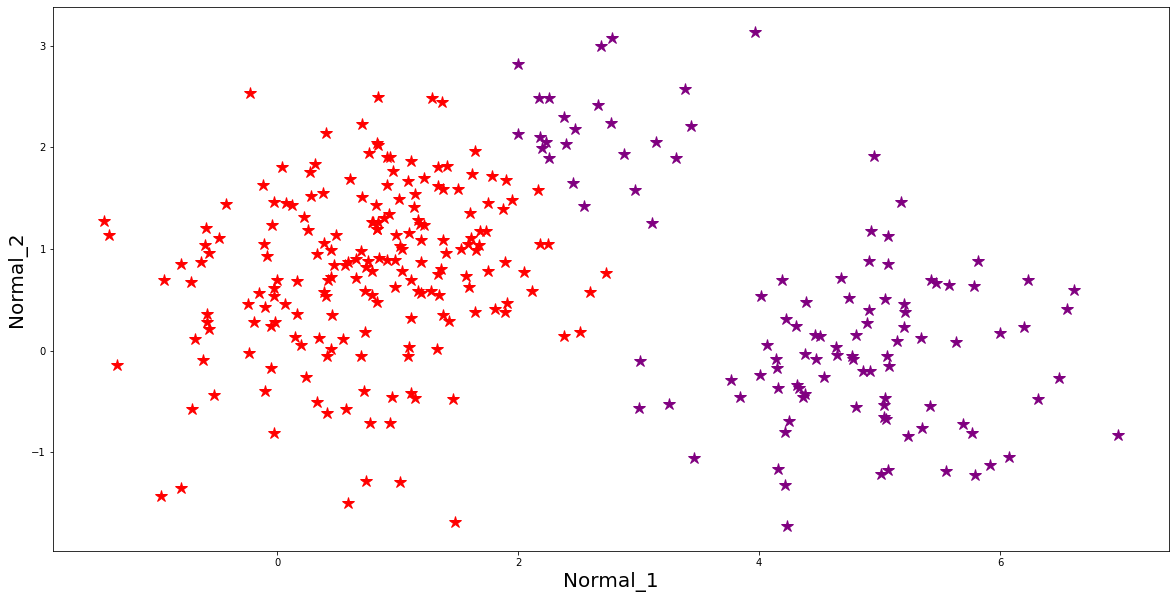

In [43]:
clusters = hierarchical(Data, 2, 'complete')
colors = ['red', 'purple']
plt.xlabel('Normal_1',fontsize=20)
plt.ylabel('Normal_2',fontsize=20)
for cluster_index, cluster in enumerate(clusters):
    for point_index, point in enumerate(cluster):
        plt.plot([point[0]], [point[1]], marker='*', markersize=12, color=colors[cluster_index])

As demonstrated above Single distance is unable to correctly identify two clusters as observations in different clusters are closer together than to observations within their own cluster in this case, whereas the complete linkage works much better in seperateing the two normall distributions.
